# Finetuning an Image Classification Model with a custom dataset in AWS SageMaker: script mode (custom training), hyperparameter tuning, model profiling and debugger, and others good ML engineering practices.


In this project the Resnet18 image classification model is finetuned with an external dataset of dog images containing 133 classes each one corresponding to a dog breed. The model is submited and deployed using Sagemaker Python SDK (SOME LINES OF CODE ARE WRITEN IN BOTO3 AND/OR CLI FOR ILUSTRATION OR SIMPLICITY..........).

The Sagemaker ML framework used is PyTorch {`sagemaker.pytorch`}. The model definition and the training and inference code are passed in to PyTorch container via Sagemaker script mode. Script mode allows for custom training and inference code while still utilizing common ML framework containers mantained by AWS.

SageMaker APIs used include: Amazon Sagemaker Debugger {`sagemaker.debugger`} to profile and debugg the training job in real time; and the Amazon Sagemaker trainning APIs HyperparameterTuner {`sagemaker.tuner.HyperparameterTuner`} and Parameters to perform hyperparameter tuning.

This notebook represents the *submission script* and contains the code to download and preprocess the data and setups to Sagemaker APIs to submit and evaluate the training job.

The *training and/or inference scrips* (`hpo.py`, `train_model.py`, and `inference.py`) contain the model definition and the training and validation code. These scripts specify hyperparameters and environmental variables through parser arguments while the *submission script* reads hyperparameters and environmental variables through command line arguments (i.e. at runtime).

More specifically, `hpo.py` script contain the code to perform hyperparameter tuning and `train_model.py` contain the code to model profiling and debugging.

The `inference.py` script contains the code to serialize the trained model and save it to S3 (`torch.save(model.state_dict(), f)`), and the code to the Sagemaker Model Server functions for deserializing the model and for translating an endpoint request to an inference call to the model. These being respectivelly, model loading function (`model_fn`) and model serving functions (`input_fn` and `prediction_fn`).


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook set-up</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">S3 configuration</a><br>
    2.2. <a href="#2.2">ETL</a><br>
    2.3. <a href="#2.3">Manifest files</a><br>
    2.4 <a href="#2.4">Define Data Channels</a>
3. <a href="#3">Hyperparameter Tuning</a><br>
    3.1. <a href="#3.1">Define training Hyperparameters and Pytorch estimator</a><br>
    3.2. <a href="#3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a>
4. <a href="#4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a><br>
    4.1. <a href="#4.1">Set-up debugging and profiling configuration (rules and hooks)</a><br>
    4.2. <a href="#4.2">Create and finetune a new model</a><br>
    4.3. <a href="#4.3">Plot debugger tensors</a><br>
    4.4. <a href="#4.4">Display profiler data (timeline chart and profiler report)</a>
5. <a href="#5">Model Deployment</a><br>
    5.1. <a href="#5.1">Create Model</a><br>
    5.2. <a href="#5.2">Create Endpoint</a><br>
    5.3. <a href="#5.3">Perform Inference</a><br>
    5.4. <a href="#5.4">Clean up</a>




**Instructor notes:** This notebook lists all the steps that you need to complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts (`train_model.py` and `hpo.py`) included with the starter code.

The TODOs in this notebook are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## 1. <a name="1">Notebook set-up</a>
(<a href="#0">Go to top</a>)

In [1]:
# TODO: Install any packages that might be needed
# For instance, smdebug package
!pip install smdebug

In [1]:
# Import any packages that might be needed
# For instance Boto3 and Sagemaker and PyTorch ML framework 
import boto3
import sagemaker

from sagemaker import get_execution_role

from sagemaker.pytorch import PyTorch

from sagemaker.tuner import(
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

from sagemaker.debugger import(
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of 7649 images of dogs. There are 6680 images in the training dataset, 836 images in the test dataset and 835 in validation dataset. It contains 133 classes of dog breeds, such as Airedale_terrier, Beagle, Bulldog, Dalmatian, etc.
The dataset was provided by @udacity/active-public-content and can be downloaded from the link https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

### 2.1. <a name="2.1">S3 configuration</a>
(<a href="#0">Go to top</a>)

In [2]:
# grab sagemaker session and define s3 bucket name or use sagemaker.Session().default_bucket
# then, define file path prefix to send data to S3 bucket

sm_session = sagemaker.Session()
bucket = sm_session.default_bucket() ##"sagemaker-us-east-1-project3" ##

prefix = "data-projeto3"

print(f"Bucket: {bucket}")
print(f"S3 path: {bucket}/{prefix}")

input_data = f"S3 path: {bucket}/{prefix}"

Bucket: sagemaker-us-east-1-837983366129
S3 path: sagemaker-us-east-1-837983366129/data-projeto3


### 2.2. <a name="2.2">ETL</a>
(<a href="#0">Go to top</a>)

In [4]:
%%time
# Fetching data from AWS S3

"""
# download and unzip data using aws CLI
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
"""

## OR

# download data using requests
# download data
import requests

url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"

# request data from url
with open('./dogImages.zip', 'wb') as f:
    f.write(requests.get(url).content)

# extract / unzip data
import shutil
shutil.unpack_archive('./dogImages.zip', './')


CPU times: user 11.1 s, sys: 3.55 s, total: 14.7 s
Wall time: 1min 16s


In [5]:
%%time
# check data integrity

## function to check for image integrity and remove invalid files
def check_data_integrity(root):
    f_count=0
    invalid_files = []

    for (r, d, f) in os.walk(root, topdown=True):
        for file in f:
            path = os.path.join(r, file)
            f_img = Image.open(path)
            try:
                f_img.load()
            except Exception as e:
                invalid_files.append(file)
                os.remove(path)
    print(f"Number of Invalid Files: {len(invalid_files)}")

## call check_data_integrity
check_data_integrity("./dogImages/train")
check_data_integrity("./dogImages/test")
check_data_integrity("./dogImages/valid")


Number of Invalid Files: 1
Number of Invalid Files: 0
Number of Invalid Files: 0
CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s


In [8]:
%%time
# upload all the data to S3
## upload local 'data' directories (train, test, and valid) to S3 with sm_session.upload_data()
## return S3 URI
input_data = sm_session.upload_data(path='./dogImages', bucket=bucket, key_prefix=prefix)
print('path to data in S3: {}'.format(input_data))

path to data in S3: s3://sagemaker-us-east-1-project3/data-projeto3
CPU times: user 49.4 s, sys: 3.3 s, total: 52.7 s
Wall time: 9min 57s


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
### Likewise, you could upload data to s3 using aws CLI (using the code in the cell bellow) instead

In [7]:
%%time
# Upload data to S3 bucket using aws CLI
aws s3 cp ./dogImages/train s3://{bucket}/{prefix}/train --recursive
aws s3 cp ./dogImages/test s3://{bucket}/{prefix}/test --recursive
aws s3 cp ./dogImages/valid s3://{bucket}/{prefix}/valid --recursive

upload failed: dogImages/ to s3://sagemaker-us-east-1-project3/data-projeto3/ [Errno 21] Is a directory: '/home/ec2-user/SageMaker/dogImages/'
CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 682 ms


In [ ]:
# -----------------------------------------------------------------------------------------

In [9]:
# delete local copy of .zip data file

if os.path.exists('./dogImages.zip'):
    os.remove('./dogImages.zip')
else:
    print("Files does not exist")

### 2.3. <a name="2.3">Manifest files</a>
(<a href="#0">Go to top</a>)

["A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column must be unique across all of the images. The set of class label indices are numbered successively and the numbering should start with 0. For example, 0 for the cat class, 1 for the dog class, and so on for additional classes."](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) (Sagemaker Developer Guide: Image Classification Algorithm. Train with Image Format)

In [3]:
# create a dictionary of classes (133 classes) that can be used later when selecting image for quering the model
  
# get the list of all files and directories in ./data/dogImages/train directory
path = "./dogImages/train"
dir_list = os.listdir(path)

dict_cls = {}
for term in dir_list:
    dict_cls[int(term.split('.')[0])-1] = term.split('.')[1]

print(f"Number of Classes: {len(dir_list)}")


Number of Classes: 133


In [4]:
dict_cls

{88: 'Irish_wolfhound',
 91: 'Keeshond',
 129: 'Welsh_springer_spaniel',
 6: 'American_foxhound',
 56: 'Dalmatian',
 4: 'Alaskan_malamute',
 44: 'Cardigan_welsh_corgi',
 51: 'Clumber_spaniel',
 12: 'Australian_terrier',
 61: 'English_setter',
 125: 'Saint_bernard',
 35: 'Briard',
 95: 'Labrador_retriever',
 110: 'Norwich_terrier',
 82: 'Ibizan_hound',
 59: 'Dogue_de_bordeaux',
 93: 'Komondor',
 100: 'Maltese',
 132: 'Yorkshire_terrier',
 106: 'Norfolk_terrier',
 3: 'Akita',
 71: 'German_shorthaired_pointer',
 108: 'Norwegian_elkhound',
 47: 'Chihuahua',
 15: 'Beagle',
 30: 'Borzoi',
 83: 'Icelandic_sheepdog',
 69: 'German_pinscher',
 55: 'Dachshund',
 101: 'Manchester_terrier',
 39: 'Bulldog',
 0: 'Affenpinscher',
 62: 'English_springer_spaniel',
 38: 'Bull_terrier',
 67: 'Flat-coated_retriever',
 54: 'Curly-coated_retriever',
 122: 'Pomeranian',
 118: 'Petit_basset_griffon_vendeen',
 13: 'Basenji',
 22: 'Bernese_mountain_dog',
 70: 'German_shepherd_dog',
 18: 'Bedlington_terrier',
 89

In [12]:
# Build a list file (.lst file) with the labels for each set of data
# "labels" are classes numbers from from 0 to 132 (133 classes)
## Note, labels start from zero (0) to meet Sagemaker requirements
# "s3_path" are dir/file_name
# "row" are the row indexes

def create_manifest_file(dir, prefix):

    path = os.path.join(dir, prefix)
    dir_list = os.listdir(path)
    dir_list.sort()

    filepath_list = []
    label_list = []
    for label in dir_list:
        directory = os.path.join(path, label)
        for (r, d, f) in os.walk(directory, topdown=True):
            for file in f:
                filepath_list.append(os.path.join(label, file))
                label_list.append(int(label.split('.')[0])-1) ## [0 to 132]

    pd.DataFrame({
        "row":range(len(filepath_list)),
        "labels":label_list,
        "s3_path":filepath_list
    }).to_csv(path_or_buf=os.path.join(dir, f"{prefix}.lst"), sep='\t', header=False, index=False)
    
    print(f"{prefix}.lst created!")

In [13]:
dir = "./dogImages/"

create_manifest_file(dir, 'train')
create_manifest_file(dir, 'test')
create_manifest_file(dir, 'valid')

train.lst created!
test.lst created!
valid.lst created!


In [14]:
%%time
# upload list files to s3

train_lst_path = sm_session.upload_data(path='./dogImages/train.lst', bucket=bucket, key_prefix=prefix)
print('train.lst uploaded to the s3 path:\n {}'.format(train_lst_path))

test_lst_path = sm_session.upload_data(path='./dogImages/test.lst', bucket=bucket, key_prefix=prefix)
print('test.lst uploaded to the s3 path:\n {}'.format(test_lst_path))

valid_lst_path = sm_session.upload_data(path='./dogImages/valid.lst', bucket=bucket, key_prefix=prefix)
print('valid.lst uploaded to the s3 path:\n {}'.format(valid_lst_path))

train.lst uploaded to the s3 path:
 s3://sagemaker-us-east-1-project3/data-projeto3/train.lst
test.lst uploaded to the s3 path:
 s3://sagemaker-us-east-1-project3/data-projeto3/test.lst
valid.lst uploaded to the s3 path:
 s3://sagemaker-us-east-1-project3/data-projeto3/valid.lst
CPU times: user 71 ms, sys: 556 µs, total: 71.5 ms
Wall time: 427 ms


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
### run the cell bellow only if the .lst files have already been uploaded to s3
### (i.e., only if you didn't run the cell above) and you need to define the paths to metadata

In [5]:
input_data = f"s3://{bucket}/data-projeto3"

train_lst_path = f"s3://{bucket}/data-projeto3/train.lst"

test_lst_path = f"s3://{bucket}/data-projeto3/test.lst"

valid_lst_path = f"s3://{bucket}/data-projeto3/valid.lst"

In [6]:
print('Bucket:\n {}'.format(bucket))

print('s3 path to data:\n {}'.format(input_data))

print('s3 path to train.lst:\n {}'.format(train_lst_path))

print('s3 path to test.lst:\n {}'.format(test_lst_path))

print('s3 path to valid.lst:\n {}'.format(valid_lst_path))

Bucket:
 sagemaker-us-east-1-837983366129
s3 path to data:
 s3://sagemaker-us-east-1-837983366129/data-projeto3
s3 path to train.lst:
 s3://sagemaker-us-east-1-837983366129/data-projeto3/train.lst
s3 path to test.lst:
 s3://sagemaker-us-east-1-837983366129/data-projeto3/test.lst
s3 path to valid.lst:
 s3://sagemaker-us-east-1-837983366129/data-projeto3/valid.lst


In [ ]:
# -----------------------------------------------------------------------------------------

### 2.4 <a name="2.4">Define Data Channels</a>
(<a href="#0">Go to top</a>)


In [7]:
# model data channels

model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/train",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/test",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/valid",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=train_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test_lst": sagemaker.inputs.TrainingInput(
        s3_data=test_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid_lst": sagemaker.inputs.TrainingInput(
        s3_data=valid_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    )
}


## 3. <a name="3">Hyperparameter Tuning</a>
(<a href="#0">Go to top</a>)

This is the part where the pretrained model is finetuned with hyperparameter tuning. 

**TODO:** Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

### 3.1. <a name="3.1">Define training Hyperparameters and Pytorch estimator</a>
(<a href="#0">Go to top</a>)

**Recommeded reading:**

1. AWS Sagemaker Read the Docs. Use PyTorch with the SageMaker Python SDK: [Deploy PyTorch Models](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

2. Amazon Sagemaker developer guide: [Image Classification Instances](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-instances)

3. AWS Sagemaker: [SageMaker instance pricing](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

In [18]:
# define hyperparameters
# Note: hyperparameters are specified and read via command line arguments 
hyperparameters = {
    'epochs':'8',
    'batch_size':'40',
    'test_batch_size':'209',
    'lr':'0.005',
}

# initialize estimators
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="sagemaker-project3", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge", #"ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

In [24]:
%%time
### fit model to check algorithm :::--->

estimator.fit(inputs=model_inputs, logs=True)

2022-06-07 18:07:35 Starting - Starting the training job...
2022-06-07 18:08:04 Starting - Preparing the instances for trainingProfilerReport-1654625255: InProgress
.........
2022-06-07 18:09:30 Downloading - Downloading input data............
2022-06-07 18:11:21 Training - Downloading the training image............
2022-06-07 18:13:36 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-07 18:13:38,958 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-07 18:13:38,981 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-07 18:13:38,988 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-07 18:13:39,519 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_

### 3.2. <a name="3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a>
(<a href="#0">Go to top</a>)

["The SageMaker Python SDK allows you to specify a name and a regular expression for metrics you want to track for training. A regular expression (regex) matches what is in the training algorithm logs, like a search function."](https://sagemaker.readthedocs.io/en/stable/overview.html#training-metrics) (Sagemaker Read the Docs: Using the SageMaker Python SDK. Using Estimators. Training Metrics)

See also:
1. Sagemaker Developer Guide: [Define Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics.html)

In [28]:
# define hyperparameters ranges
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.01, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([40, 60]),
}

# objective metric to be used (added to HyperparameterTuner bellow)
objective_metric_name = "average test loss"

# define whether the metric needs to be minimized or maximized
objective_type = "Minimize"

# tell sagemaker what to look for in the logs (define training metrics)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [29]:
# create hyperparameter tuner object and pass in the estimator
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=6, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=prefix,
)

In [30]:
%%time
tuner.fit(inputs=model_inputs, wait=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [33]:
tuner_best_training_job = tuner.best_training_job()

print("Best training job: {}".format(tuner_best_training_job))

Best training job: data-projeto3-220607-1831-005-8e19c950


In [34]:
# Grab the best estimators and the best HPs

#Get the best trained model
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = tuner.best_estimator().hyperparameters()

print("Best estimator: {} \nBest hyperparameters: {}".format(best_estimator, best_estimator_hyperparameters))


2022-06-07 20:13:13 Starting - Preparing the instances for training
2022-06-07 20:13:13 Downloading - Downloading input data
2022-06-07 20:13:13 Training - Training image download completed. Training in progress.
2022-06-07 20:13:13 Uploading - Uploading generated training model
2022-06-07 20:13:13 Completed - Training job completed

2022-06-07 20:13:13 Starting - Preparing the instances for training
2022-06-07 20:13:13 Downloading - Downloading input data
2022-06-07 20:13:13 Training - Training image download completed. Training in progress.
2022-06-07 20:13:13 Uploading - Uploading generated training model
2022-06-07 20:13:13 Completed - Training job completed
Best estimator: <sagemaker.pytorch.estimator.PyTorch object at 0x7f0ed58c5828> 
Best hyperparameters: {'_tuning_objective_metric': '"average test loss"', 'batch_size': '"40"', 'epochs': '"8"', 'lr': '0.0010544455247863843', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimat

In [35]:
results = tuner.analytics()
results_df = results.dataframe()

results_df

,batch_size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""60""",0.010000,data-projeto3-220607-1831-006-ebc0bc61,Completed,0.083157,2022-06-07 20:15:12+00:00,2022-06-07 20:32:49+00:00,1057.0
1,"""40""",0.001054,data-projeto3-220607-1831-005-8e19c950,Completed,0.021583,2022-06-07 19:54:51+00:00,2022-06-07 20:13:13+00:00,1102.0
2,"""40""",0.005546,data-projeto3-220607-1831-004-9d06ddb2,Completed,0.065544,2022-06-07 19:34:26+00:00,2022-06-07 19:52:02+00:00,1056.0
3,"""40""",0.003141,data-projeto3-220607-1831-003-489641bf,Completed,0.041725,2022-06-07 19:14:08+00:00,2022-06-07 19:32:10+00:00,1082.0
4,"""40""",0.001583,data-projeto3-220607-1831-002-4af87869,Completed,0.024585,2022-06-07 18:53:39+00:00,2022-06-07 19:11:46+00:00,1087.0
5,"""60""",0.003929,data-projeto3-220607-1831-001-7d7099e1,Completed,0.036273,2022-06-07 18:33:33+00:00,2022-06-07 18:51:42+00:00,1089.0


**Grab best training parameters**

In [37]:
epochs =  ''.join(i for i in best_estimator_hyperparameters['epochs'] if i.isalnum())
print(f"epochs: {epochs}")

epochs: 8


In [46]:
test_batch_size =  ''.join(i for i in best_estimator_hyperparameters['test_batch_size'] if i.isalnum())
print(f"Test batch_size: {test_batch_size}")

Test batch_size: 209


In [39]:
best_batch_size = ''.join(i for i in best_estimator_hyperparameters['batch_size'] if i.isalnum())
print(f"Best batch_size: {best_batch_size}")

Best batch_size: 40


In [40]:
best_lr =  ''.join(i for i in best_estimator_hyperparameters['lr'] if i.isalnum())
print(f"Best lr: {best_lr}")

Best lr: 00010544455247863843


In [ ]:
# -----------------------------------------------------------------------------------------

In [8]:
epochs = '8'
test_batch_size = '209'
best_batch_size = '40'
best_lr = '0.0010544455247863843'

In [ ]:
# -----------------------------------------------------------------------------------------

In [77]:
## another way of getting the best training job description

sagemaker_boto_client = boto3.Session().client(service_name="sagemaker")

best_training_job_summary = results.description()["BestTrainingJob"]

best_training_job_summary

{'TrainingJobName': 'data-projeto3-220607-1831-005-8e19c950',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:543585564521:training-job/data-projeto3-220607-1831-005-8e19c950',
 'CreationTime': datetime.datetime(2022, 6, 7, 19, 52, 59, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 6, 7, 19, 54, 51, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 6, 7, 20, 13, 13, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch_size': '"40"', 'lr': '0.0010544455247863843'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.02158300019800663},
 'ObjectiveStatus': 'Succeeded'}

## 4. <a name="4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a>
(<a href="#0">Go to top</a>)

Create and finetune a new model using the best hyperparameters, found in the previous section (**Hyperparameter Tuning**).

**Note:** use the `train_model.py` script to perform model profiling and debugging.

**Support reading:**

1. Sagemaker Developer Guide: [Amazon SageMaker Debugger API Operations](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-apis.html)

2. Sagemaker Developer Guide: [Configure Debugger Using Amazon SageMaker Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configuration.html)

3. Sagemaker Read the Docs: [Sagemaker Debugger](https://sagemaker.readthedocs.io/en/stable/api/training/debugger.html#)


### 4.1. <a name="4.1">Set-up debugging and profiling configuration (rules and hooks)</a>
(<a href="#0">Go to top</a>)

In [41]:
# grab default_bucket name
bucket = sm_session.default_bucket()  ##"sagemaker-us-east-1-project3"
print(f"Bucket:{bucket}")

Bucket:sagemaker-us-east-1-543585564521


In [42]:
# configure debugger and profiler rules
rules = [
    ## debugger
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ## profiler
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


In [43]:
# define tensor collections for SageMaker Debugger
collection_configs = [
    CollectionConfig(
        name = 'all',
        parameters={
            "include_regex": ".*",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
    
]

# define debugger (hook) configuration
hook_config = DebuggerHookConfig(
    s3_output_path = f"s3://{bucket}/project3/debug-output",
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    },
    collection_configs = collection_configs
)


In [ ]:
##-----------------------------------------------------------------------

In [ ]:
# OR, a short way, without defining collections, to define debugger config is bellow

In [28]:
hook_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/project3/debug-output",
    hook_parameters={
        "train.save_interval":"100",
        "eval.save_interval":"10"
    }
)

In [ ]:
##-----------------------------------------------------------------------

In [44]:
# define the profiler configuration
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

### 4.2. <a name="4.2">Create and finetune a new model</a>
(<a href="#0">Go to top</a>)

In [48]:
# Create and fit an estimator with hyperparameters of the best model found in the previous section
# pass debugging and profiling rules and hooks to the estimator

hyperparameters = {
    'epochs': epochs,
    'batch_size': best_batch_size,
    'test_batch_size': test_batch_size,
    'lr': best_lr,
}

best_estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="bestmodel-project3", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge", #"ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    rules=rules,
)


In [49]:
%%time

best_estimator.fit(inputs=model_inputs, wait=True)

2022-06-07 20:48:36 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-06-07 20:49:34 Starting - Preparing the instances for training......
2022-06-07 20:50:34 Downloading - Downloading input data............
2022-06-07 20:52:35 Training - Downloading the training image.....................
2022-06-07 20:56:09 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-07 20:56:11,827 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-07 20:56:11,852 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-07 20:56:11,869 sagemaker_pytorch_container.training INFO     Invoking user 

In [50]:
# get a full description of the training job
job_name = best_estimator.latest_training_job.name
client = best_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName = job_name)

print(f"Training job name: {job_name}")
print(f"Description: {description}")

Training job name: bestmodel-project3-2022-06-07-20-48-36-294
Description: {'TrainingJobName': 'bestmodel-project3-2022-06-07-20-48-36-294', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:543585564521:training-job/bestmodel-project3-2022-06-07-20-48-36-294', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '"40"', 'epochs': '"8"', 'lr': '"0.0010544455247863843"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"bestmodel-project3-2022-06-07-20-48-36-294"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/source/sourcedir.tar.gz"', 'test_batch_size': '"209"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws

### 4.3. <a name="4.3">Plot debugger tensors</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. GitHub: [Tensor Analysis Using Amazon SageMaker Debugger](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb)

2. Sagemaker Developer Guide: [Visualize SageMaker Debugger Output Tensors](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-enable-tensorboard-summaries.html)

In [51]:
# retrieve s3 location of debugger tensors
tensors_path = best_estimator.latest_job_debugger_artifacts_path()
print("S3 path to debugger tensors: ", tensors_path)

S3 path to debugger tensors:  s3://sagemaker-us-east-1-543585564521/project3/debug-output/bestmodel-project3-2022-06-07-20-48-36-294/debug-output


In [52]:
# Create an smdebug Trial object to retrieve the saved tensors

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(tensors_path)

# Fetch tensor names and print their lengths
trial.tensor_names()

[2022-06-07 21:21:51.184 ip-172-16-67-227:19264 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-06-07 21:21:51.240 ip-172-16-67-227:19264 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-543585564521/project3/debug-output/bestmodel-project3-2022-06-07-20-48-36-294/debug-output


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-06-07 21:21:52.515 ip-172-16-67-227:19264 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-06-07 21:21:53.535 ip-172-16-67-227:19264 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_input_0',
 'CrossEntropyLoss_input_1',
 'CrossEntropyLoss_output_0',
 'ResNet_bn1.bias',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.bias',
 'ResNet_fc.0.weight',
 'ResNet_input_0',
 'ResNet_layer1.0.bn1.bias',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.bias',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.1.bn1.bias',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.bias',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer2.0.bn1.bias',
 'ResNet_layer2.0.bn1.weight',
 'ResNet_layer2.0.bn2.bias',
 'ResNet_layer2.0.bn2.weight',
 'ResNet_layer2.0.conv1.weight',
 'ResNet_layer2.0.conv2.weight',
 'ResNet_layer2.0.downsample.0.weight',
 'ResNet_layer2.0.downsample.1.bias',
 'ResNet_layer2.0.downsample.1.weight',
 'ResNet_layer2.1.bn1.bias',
 'ResNet_layer2.1.bn1.weight',
 'ResNet_layer2.1.bn2.bias',
 'ResNet_layer2.1.

In [53]:
## testing accessing individual tensors with regex

## regex=".*gradient" to retrieve gradients
## options are (regex=".*input", regex=".*output", regex=".*gradient" and regex=".*weight")
## see https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb

test_tensor = trial.tensor_names(regex=".*output")[0]
test_tensor

'CrossEntropyLoss_output_0'

In [54]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.TRAIN))

14

In [55]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.EVAL))

1

In [56]:
# create functions to plot an output tensor

from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


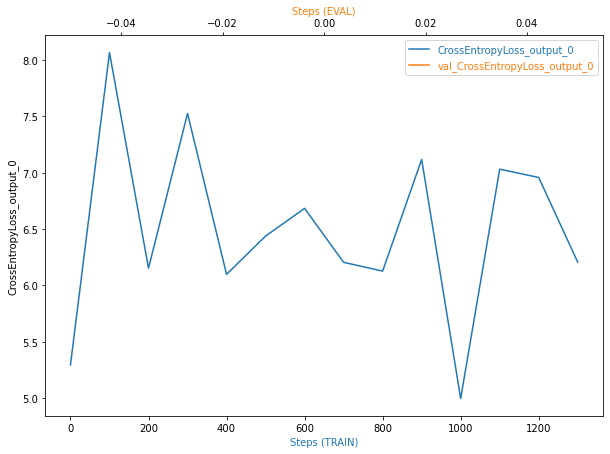

In [57]:
plot_tensor(trial, test_tensor)

**Considerations:**

**TODO**:<br>
&emsp; &emsp; &emsp; **- Is there some anomalous behaviour in your debugging output? If so, what is the error and how can it be fixed?**

&emsp; &emsp; &emsp; **- If there is not, then, let's suppose there was an error. What would that error look like and how could it be fixed?**

### 4.4. <a name="4.4">Display profiler data (timeline chart and profiler report)</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. Sagemaker Developer Guide: [Plot the System Metrics and Framework Metrics Data](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-access-data-profiling-default-plot.html)

In [58]:
### use TrainingJob object to fetch system metrics saved to s3
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

region=sagemaker.Session().boto_region_name

tj = TrainingJob(job_name, region)

# check if profile data is available
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-543585564521/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/profiler-output


Profiler data from system is available


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [59]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()
framework_metrics_reader = tj.get_framework_metrics_reader()

view_heatmap = Heatmap(
    system_metrics_reader,
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
    plot_height=450
)

[2022-06-07 21:23:40.799 ip-172-16-67-227:19264 INFO metrics_reader_base.py:134] Getting 25 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization', 'I/OWaitPercentage', 'CPUUtilization', 'GPUMemoryUtilization'}


In [61]:
# Fetch the path to profiler output

rule_output_path = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/rule-output"

print(f"You will find the profiler report in\n {rule_output_path}")

You will find the profiler report in
 s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/rule-output


In [62]:
# list s3 objects into the rule_output path
! aws s3 ls {rule_output_path} --recursive

2022-06-07 21:14:37     442335 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-06-07 21:14:37     302590 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-06-07 21:14:32        568 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-06-07 21:14:32      72584 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-06-07 21:14:32       1902 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-06-07 21:14:32        130 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-06-07 21:14:32      28656 bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-outp

In [65]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06-07-20-48-36-294/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-543585564521/bestmodel-project3-2022-06

In [66]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in best_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [67]:
# display the SageMaker Debugger profiling report

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## 5. <a name="5">Model Deployment</a>
(<a href="#0">Go to top</a>)

**Recommeded reading:**

1. Sagemaker Developer Guide: [Request Inferences from a Deployed Service](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-requests-sdk.html)
2. Sagemaker Read the Docs: [End-to-End Multiclass Image Classification Example](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html#Create-endpoint-configuration)
3. Use PyTorch with the SageMaker Python SDK. Deploy PyTorch Models. [The SageMaker PyTorch Model Server](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#id3)
4. AWS Blog: [Bring your own model with Amazon SageMaker script mode](https://aws.amazon.com/blogs/machine-learning/bring-your-own-model-with-amazon-sagemaker-script-mode/)
5. Sagemaker Developer Guide: [Deploy a Compiled Model Using SageMaker SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-deployment-hosting-services-sdk.html)
6. Sagemaker Read the Docs: [Predictors](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor)

In [ ]:
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::======>>>>

### 5.1. <a name="5.1">Create Model</a>
(<a href="#0">Go to top</a>)

In [8]:
epochs = '8'
test_batch_size = '209'
best_batch_size = '40'
best_lr = '0.0010544455247863843'

In [ ]:
%%time

hyperparameters = {
    'epochs': epochs,
    'batch_size': best_batch_size,
    'test_batch_size': test_batch_size,
    'lr': best_lr
}

model = PyTorch(
    entry_point="inference.py",
    base_job_name="model-project3", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge", #"ml.p3.2xlarge", #
    hyperparameters=hyperparameters,
    framework_version="1.8.0",
    py_version="py36"
)
#source_dir='pytorch_script',

model.fit(inputs=model_inputs, wait=True)

2022-06-20 17:31:21 Starting - Starting the training job...
2022-06-20 17:31:48 Starting - Preparing the instances for trainingProfilerReport-1655746281: InProgress
............
2022-06-20 17:33:46 Downloading - Downloading input data...............
2022-06-20 17:36:07 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-20 17:39:39,394 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-20 17:39:39,425 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-20 17:39:39,436 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-20 17:39:40,835 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "test_lst


2022-06-20 17:39:48 Training - Training image download completed. Training in progress.Number of gpus available - 1
Running on device cuda
[2022-06-20 17:39:53.189 algo-1:26 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-06-20 17:39:53.452 algo-1:26 INFO profiler_config_parser.py:102] User has disabled profiler.
[2022-06-20 17:39:53.452 algo-1:26 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2022-06-20 17:39:53.453 algo-1:26 INFO hook.py:199] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2022-06-20 17:39:53.454 algo-1:26 INFO hook.py:253] Saving to /opt/ml/output/tensors
[2022-06-20 17:39:53.454 algo-1:26 INFO state_store.py:77] The checkpoint config file /opt/ml/input/config/checkpointconfig.json does not exist.
[2022-06-20 17:39:54.277 algo-1:26 INFO hook.py:584] name:fc.0.weight count_params:68096
[2022-06-20 17:39:54.277 algo-1:26 INFO hook.py:584] name:fc.0.

In [10]:
print(f"Training job name: {model.latest_training_job.name}")

model_data_location = f"s3://{bucket}/{model.latest_training_job.name}/output/model.tar.gz"

print(f"Model data location in s3: {model_data_location}")

Training job name: model-project3-2022-06-20-17-31-21-035
Model data location in s3: s3://sagemaker-us-east-1-837983366129/model-project3-2022-06-20-17-31-21-035/output/model.tar.gz


### 5.2. <a name="5.2">Create Endpoint</a>
(<a href="#0">Go to top</a>)

In [11]:
%%time
# deploy model to an endpoint

predictor = model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.p2.xlarge" #"ml.m5.xlarge" #
)

------------------------------------------------------------------------------------------------------*

UnexpectedStatusException: Error hosting endpoint model-project3-2022-06-20-18-00-42-756: Failed. Reason:  The customer:primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

In [ ]:
# grab endpoint name
print(f"Endpoint name: {predictor.endpoint_name}")

In [19]:
# print the status of the endpoint
client = boto3.client('sagemaker')
endpoint_response = client.describe_endpoint(EndpointName=predictor.endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

Endpoint creation ended with EndpointStatus = InService


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


### 5.3. <a name="5.3">Perform Inference</a>
(<a href="#0">Go to top</a>)

#### 5.3.1. <a name="5.3.1">Grab validation data</a>

In [20]:
# create a list of classes sorted by indexes
image_categories = []
for i in sorted(dict_cls.keys()):
    image_categories.append(dict_cls[i])

In [16]:
image_categories

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

In [25]:
# random select from the dictionary of classes created at the begining of the notebook
image_class = random.choice(dir_list)
print(f"Class: {image_class}")

class_path = f"./dogImages/valid/{image_class}"
print(f"Path to files in this class: {class_path}")

# select random image from selected class
image = random.choice(os.listdir(class_path))
print(f"Selected image: {image}")

local_image_path = f"{class_path}/{image}"
print(f"Local path to selected image: {image_path}")


Class: 088.Irish_water_spaniel
Path to files in this class: ./dogImages/valid/088.Irish_water_spaniel
Selected image: Irish_water_spaniel_05990.jpg
Local path to selected image: ./dogImages/valid/088.Irish_water_spaniel/Irish_water_spaniel_05990.jpg


In [30]:
s3_image_path = f"s3://{bucket}/data-projeto3/valid/{image_class}/{image}"

print(f"S3 path to selected image: {image_path}")

S3 path to selected image: s3://sagemaker-us-east-1-837983366129/data-projeto3/valid/088.Irish_water_spaniel/Irish_water_spaniel_05990.jpg


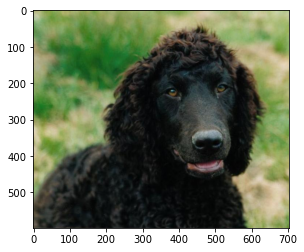

In [26]:
# plot selected image(s)
plt.imshow(plt.imread(local_image_path))

#### 5.3.2. <a name="5.3.2">Test endpoint</a>

In [ ]:
## prediction trial 00.0:::-->

In [ ]:
payload = s3_image_path

result = predictor.predict(data = payload)

In [24]:
with open(image_path, 'rb') as f:
    payload = f.read()
    
result = predictor.predict(data = payload)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-06-14-19-39-01-598 in account 543585564521 for more information.

In [ ]:
## prediction trial 00.1:::-->

In [26]:
from skimage.transform import resize
import matplotlib.pyplot as plt

image = plt.imread(image_path)
resized_image = resize(image, (244, 244))

In [27]:
result = predictor.predict(data = resized_image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-06-14-19-39-01-598 in account 543585564521 for more information.

In [ ]:
## prediction trial 01:::-->

In [ ]:
# run a prediction on the endpoint using Boto3
runtime = boto3.Session().client(service_name="runtime.sagemaker")

In [29]:
inference_response = runtime.invoke_endpoint(
    EndpointName = predictor.endpoint_name,
    ContentType="application/x-image",
    Body=local_image_path,
)

# result will be in json format
result = inference_response["Body"].read()

# convert result to ndarray
result = json.loads(result)

ReadTimeoutError: Read timeout on endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/model-project3-2022-06-16-09-46-44-568/invocations"

In [ ]:
## prediction trial 02:::-->

In [ ]:
inference_response = runtime.invoke_endpoint(
    EndpointName = predictor.endpoint_name,
    ContentType="application/x-image",
    Body=s3_image_path,
)

In [ ]:
# result will be in json format
result = inference_response["Body"].read()
#result = inference_response['Body'].read().decode('utf-8')

# convert result to ndarray
result = json.loads(result)

**PRINT PREDICTION(S)!!!**

In [ ]:
# the result will output the probabilities for all classes
# find the class with maximum probability
index = np.argmax(input = result, dim = 1)

# print the most probable class and its probability
for index in result:
    print(f"Result: predicted label(s) - {image_categories[index]}")

### 5.4. <a name="5.4">Clean up</a>
(<a href="#0">Go to top</a>)

*Delete model and endpoint:*

**Reading:**

1. [Clean Up -- AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html)

In [ ]:
# shutdown/delete the endpoint once the work is done

print(f"deleting endpoint: {predictor.endpoint_name}")
sm_session.delete_endpoint(endpoint_name = predictor.endpoint_name)
### runtime.delete_endpoint(EndpointName = predictor.endpoint_name)

print(f"deleting Model: {model.latest_training_job.name}")
# sm_session.delete_model(predictor.endpoint)
### runtime.delete_model(ModelName = predictor.endpoint_name)